In [1]:
import os 
import pandas as pd
import sys
import matplotlib.pyplot as plt
os.getcwd()
os.chdir('/Volumes/AHN/captive_ape_microbiome/')

codiversifying_clades/data/Bacteroidaceae.fna

This script explores how to assign taxonomy to gyrb amplicon data using blastn and blastx searches. We first examine how the supplement data from Moeller et al. 2016 aligned with the gtdbtk-gyrb-bt database generated. 

These explorations of the data show that it's necessary to use blastx to identify some sequences found in wild apes that aren't similar to humans and so are missed by blastn search. 

These analyses also show which percent identity and alignment length threshold cutoffs are useful for filtering ASVs. For instance, we don't want to use cutoffs that remove wild ape reads identified in Moeller et al. 

#### Use seqs from Moeller et al 2016 as a guide for not eliminating co-diversified strains
See what is the average percent identity these strains align to reference database through blastn and blastx searches.

In [2]:
%%bash
prot_db=results/gyrb_bt_gtdbtk_ref/blast_db/gtdbtk_gyrb_amplicon.faa
nucl_db=results/gyrb_bt_gtdbtk_ref/blast_db/gtdbtk_gyrb_amplicon.fasta
moeller_2016_fasta=codiversifying_clades/data/Bacteroidaceae.fna
outdir=codiversifying_clades/results
mkdir $outdir

blastn \
    -query $moeller_2016_fasta \
    -db $nucl_db \
    -outfmt "7 qseqid sacc pident qlen length evalue bitscore salltitles sseq" \
    -out $outdir/blastn_out.txt
blastx \
    -query $moeller_2016_fasta \
    -db $prot_db \
    -outfmt "7 qseqid sacc pident qlen length evalue bitscore salltitles sseq" \
    -out $outdir/blastx_out.txt

mkdir: codiversifying_clades/results: File exists


total number of blastn hits
624
total number of blastx hits
729


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


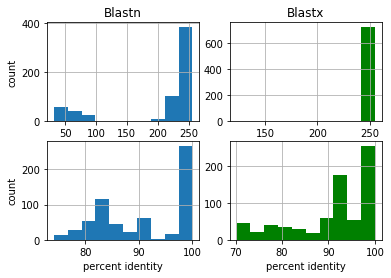

In [11]:
#Blastn results summay
blastn_res='codiversifying_clades/results/blastn_out.txt'
blastn_res=pd.read_csv(blastn_res, sep='\t', comment='#',header=None)
blastn_res.columns=['ASV','sacc','pident','qlen','length','evalue','bitscore','salltitles','sseq']  
blastn_res=blastn_res.groupby('ASV').head(1) #get top hit
blastn_res[['GenomeDomain','Phylum','Class','Order',
                'Family','Genus','Species']]= blastn_res['salltitles'].str.split(';',expand=True)
blastn_res.to_csv('codiversifying_clades/results/blastn_df.txt',sep='\t')
print('total number of blastn hits')
print(len(blastn_res))

#blastx results
blastx_res='codiversifying_clades/results/blastx_out.txt'
blastx_res=pd.read_csv(blastx_res, sep='\t', comment='#',header=None)
blastx_res.columns=['ASV','sacc','pident','qlen','length','evalue','bitscore','salltitles','sseq']  
blastx_res=blastx_res.groupby('ASV').head(1) #get top hit
blastx_res[['GenomeDomain','Phylum','Class','Order',
                'Family','Genus','Species']]=blastx_res['salltitles'].str.split(';',expand=True)
blastx_res['length'] = blastx_res['length']*3
blastx_res.to_csv('codiversifying_clades/results/blastx_df.txt',sep='\t')
print('total number of blastx hits')
print(len(blastx_res))

blastxn = blastn_res.merge(blastx_res,on='ASV',how='outer')
blastxn.columns = [x.replace('_x','_blastn').replace('_y','_blastx') for x in blastxn.columns]

def plot_pident_palign(df):
    fig = plt.figure()

    ax1 = fig.add_subplot(221)
    df['length_blastn'].hist()
    plt.xlabel('alignment length')
    plt.ylabel('count')
    plt.title('Blastn')

    ax2 = fig.add_subplot(222)
    df['length_blastx'].hist(facecolor='green')
    plt.xlabel('alignment length')
    plt.title('Blastx')

    ax3 = fig.add_subplot(223)
    df['pident_blastn'].hist()
    plt.xlabel('percent identity')
    plt.ylabel('count')

    ax4 = fig.add_subplot(224)
    df['pident_blastx'].hist(facecolor='green')
    plt.xlabel('percent identity')
    fig.show()
plot_pident_palign(blastxn)

105


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


o__Bacteroidales       646
o__Flavobacteriales     83
Name: Order_blastx, dtype: int64

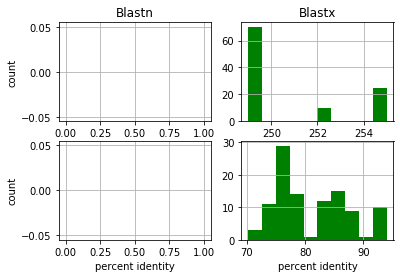

In [12]:
#Unassigned by blastn
blastn_Unassigned = blastxn[blastxn['Order_blastn'].isna()]
print(len(blastn_Unassigned))

plot_pident_palign(blastn_Unassigned)

blastxn['Order_blastx'].value_counts()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


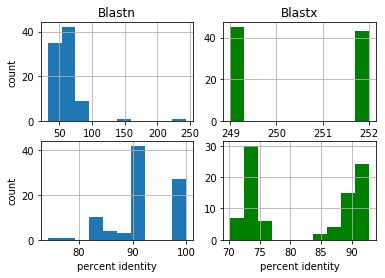

In [5]:
#families dont match
#Blastn results short alignment length of those that don't match
families_dont_match = blastxn[blastxn['Order_blastn']==blastxn['Order_blastx']]
families_dont_match = families_dont_match[families_dont_match['Family_blastn']!=families_dont_match['Family_blastx']]
families_dont_match.to_csv('codiversifying_clades/results/blastnx_fam_dont_match.txt',sep='\t')
plot_pident_palign(families_dont_match)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


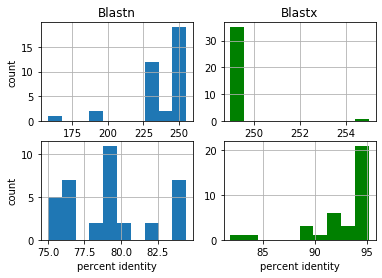

In [6]:
#analyzing hits where genera do not match
#blastn identity isn't over 85%
genera_dont_match = blastxn[blastxn['Family_blastn']==blastxn['Family_blastx']]
genera_dont_match = genera_dont_match[genera_dont_match['Genus_blastn']!=genera_dont_match['Genus_blastx']]
genera_dont_match.to_csv('codiversifying_clades/results/blastnx_gen_dont_match.txt',sep='\t')
plot_pident_palign(genera_dont_match)

total number of blastn hits
1007
total number of blastx hits
3147


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


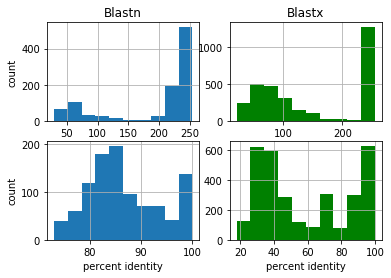

In [9]:
#Blastn results summay
blastn_res='results/gyrb_all/Bt/assigned_taxonomy/ASVs_blastn.txt'
blastn_res=pd.read_csv(blastn_res, sep='\t', comment='#',header=None)
blastn_res.columns=['ASV','sacc','pident','qlen','length','evalue','bitscore','salltitles','sseq']  
blastn_res=blastn_res.groupby('ASV').head(1) #get top hit
blastn_res[['GenomeDomain','Phylum','Class','Order',
                'Family','Genus','Species']]= blastn_res['salltitles'].str.split(';',expand=True)
print('total number of blastn hits')
print(len(blastn_res))

#blastx results summay
blastx_res='results/gyrb_all/Bt/assigned_taxonomy/ASVs_blastx.txt'
blastx_res=pd.read_csv(blastx_res, sep='\t', comment='#',header=None)
blastx_res.columns=['ASV','sacc','pident','qlen','length','evalue','bitscore','salltitles','sseq']  
blastx_res=blastx_res.groupby('ASV').head(1) #get top hit
blastx_res[['GenomeDomain','Phylum','Class','Order',
                'Family','Genus','Species']]= blastx_res['salltitles'].str.split(';',expand=True)
blastx_res['length']=blastx_res['length']*3
print('total number of blastx hits')
print(len(blastx_res))

blastxn = blastn_res.merge(blastx_res,on='ASV',how='outer')
blastxn.columns = [x.replace('_x','_blastn').replace('_y','_blastx') for x in blastxn.columns]
blastxn.to_csv('results/gyrb_all/Bt/assigned_taxonomy/ASVs_blastxn_merged.txt',sep='\t')

plot_pident_palign(blastxn)

1295 hits after 80% AA alignment length threshold cutoff
1278 hits after 50% AA percent identity threshold cutoff
279 hits assigned by blastx, but not by blastn
226 hits where family assignment differs between blastx and blastn


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


98 hits where genus assignment differs between blastx and blastn
87.678 nucleotide identity above which genus assignment is consistent


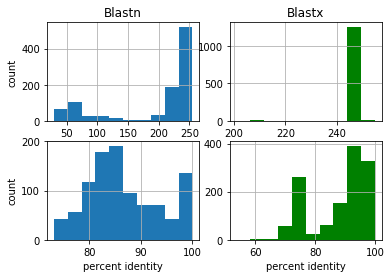

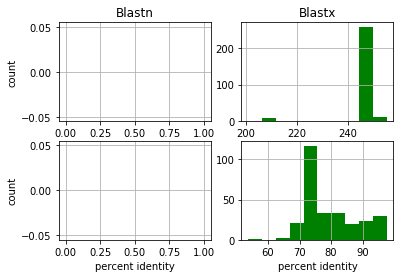

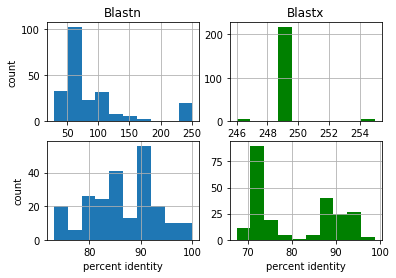

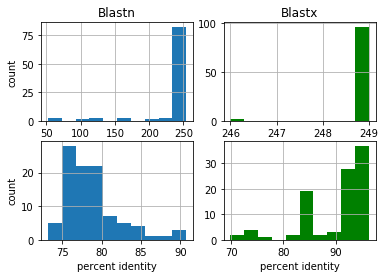

In [198]:
#define blastx filtering
len_cutoff=.8
pident_cutoff=50
blastx_filt = blastxn[blastxn['length_blastx']>249*len_cutoff]
print(len(blastx_filt),'hits after 80% AA alignment length threshold cutoff')
blastx_filt = blastx_filt[blastx_filt['pident_blastx']>pident_cutoff]
print(len(blastx_filt),'hits after 50% AA percent identity threshold cutoff')
plot_pident_palign(blastx_filt)


#Unassigned by blastn
blastx_filt_Unassigned = blastx_filt[blastx_filt['Order_blastn'].isna()]
print(len(blastx_filt_Unassigned),'hits assigned by blastx, but not by blastn')
plot_pident_palign(blastx_filt_Unassigned)

#families dont match
#Blastn results short alignment length of those that don't match
families_dont_match = blastx_filt[blastx_filt['Order_blastn']==blastx_filt['Order_blastx']]
families_dont_match = families_dont_match[families_dont_match['Family_blastn']!=families_dont_match['Family_blastx']]
print(len(families_dont_match),'hits where family assignment differs between blastx and blastn')
families_dont_match.to_csv('results/gyrb_all/Bt/assigned_taxonomy/blastnx_fam_dont_match.txt',sep='\t')
plot_pident_palign(families_dont_match)

#analyzing hits where genera do not match
#blastn identity isn't over 85%
genera_dont_match = blastx_filt[blastx_filt['Family_blastn']==blastx_filt['Family_blastx']]
genera_dont_match = genera_dont_match[genera_dont_match['Genus_blastn']!=genera_dont_match['Genus_blastx']]
genera_dont_match.to_csv('results/gyrb_all/Bt/assigned_taxonomy/blastnx_gen_dont_match.txt',sep='\t')
plot_pident_palign(genera_dont_match)

print(len(genera_dont_match),'hits where genus assignment differs between blastx and blastn')
genera_dont_match_good_blastn = genera_dont_match[genera_dont_match['length_blastn']>(249*.8)]
print(max(genera_dont_match_good_blastn['pident_blastn']),
      'nucleotide identity above which genus assignment is consistent')



In [147]:
#ASVs missed by blastn
ASV_missed_blastx = set(blastx_filt['ASV'])-set(blastn_res['ASV'])
print(len(ASV_missed_blastx))
ASV_missed_blastx = blastx_res[blastx_res['ASV'].isin(ASV_missed_blastx)]
#ASVs missed by blastx
ASV_missed_blastn = set(blastn_res['ASV'])-set(blastx_filt['ASV'])
print(len(ASV_missed_blastn))
ASV_missed_blastn = blastn_res[blastn_res['ASV'].isin(ASV_missed_blastn)]


1295
1278
279
8


279


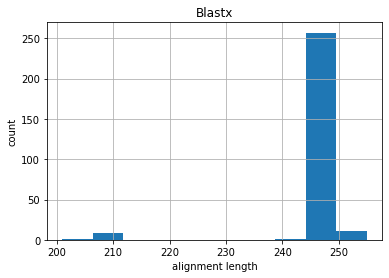

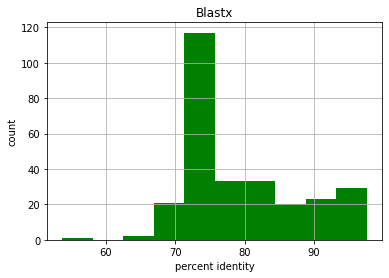

In [150]:
blastxn = blastn_res.merge(blastx_filt,on='ASV',how='outer')
blastxn.columns = [x.replace('_x','_blastn').replace('_y','_blastx') for x in blastxn.columns]
blastxn.head()

#Unassigned by blastn
blastn_Unassigned = blastxn[blastxn['Order_blastn'].isna()]
print(len(blastn_Unassigned))
(blastn_Unassigned['length_blastx']*3).hist() #length in terms of nucleotides
plt.title('Blastx')
plt.xlabel('alignment length')
plt.ylabel('count')
plt.show()
plt.show()
blastn_Unassigned['pident_blastx'].hist(facecolor='green')
plt.title('Blastx')
plt.xlabel('percent identity')
plt.ylabel('count')
plt.show()

226


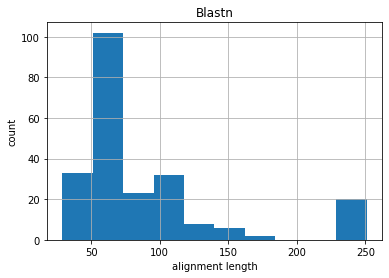

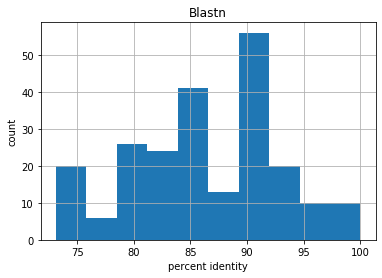

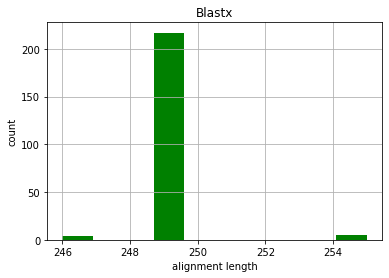

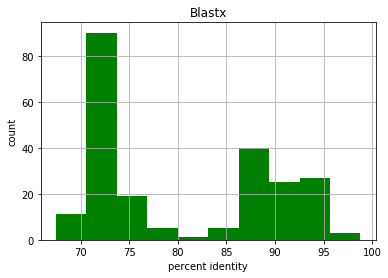

In [153]:
#Analyze hits where bacterial families don't match
#Blastn results short alignment length

families_dont_match = blastxn[blastxn['Order_blastn']==blastxn['Order_blastx']]
families_dont_match = families_dont_match[families_dont_match['Family_blastn']!=families_dont_match['Family_blastx']]
families_dont_match.to_csv('results/gyrb_all/Bt/assigned_taxonomy/blastnx_fam_dont_match.txt',sep='\t')
#also includes unassigned by blast n search

print(len(families_dont_match))
families_dont_match['length_blastn'].hist() #length in terms of nucleotides
plt.title('Blastn')
plt.xlabel('alignment length')
plt.ylabel('count')
plt.show()
plt.show()
families_dont_match['pident_blastn'].hist()
plt.title('Blastn')
plt.xlabel('percent identity')
plt.ylabel('count')
plt.show()

(families_dont_match['length_blastx']*3).hist(facecolor='green') #length in terms of nucleotides
plt.title('Blastx')
plt.xlabel('alignment length')
plt.ylabel('count')
plt.show()
plt.show()
families_dont_match['pident_blastx'].hist(facecolor='green')
plt.title('Blastx')
plt.xlabel('percent identity')
plt.ylabel('count')
plt.show()


98


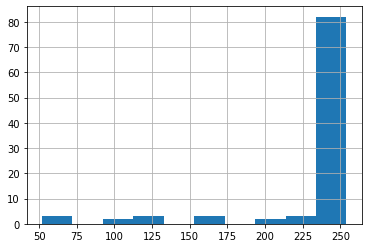

90.741


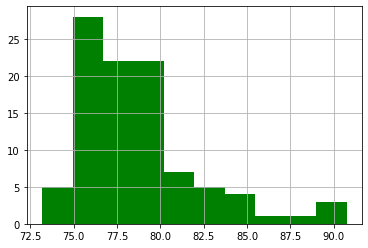

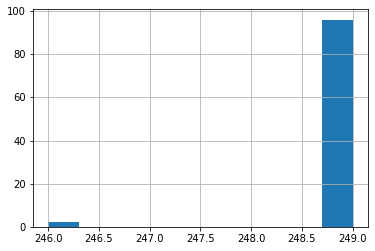

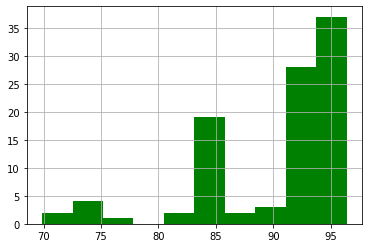

In [154]:
#analyzing hits where genera do not match
#blastn identity isn't over 85%

genera_dont_match = blastxn[blastxn['Family_blastn']==blastxn['Family_blastx']]
genera_dont_match = genera_dont_match[genera_dont_match['Genus_blastn']!=genera_dont_match['Genus_blastx']]
genera_dont_match.to_csv('results/gyrb_all/Bt/assigned_taxonomy/blastnx_gen_dont_match.txt',sep='\t')
print(len(genera_dont_match))


genera_dont_match['length_blastn'].hist()
plt.show()
genera_dont_match['pident_blastn'].hist(facecolor='green')
print(max(genera_dont_match['pident_blastn']))
plt.show()
(genera_dont_match['length_blastx']*3).hist() #length in terms of nucleotides
plt.show()
genera_dont_match['pident_blastx'].hist(facecolor='green')



In [99]:
def filter_rows(pident,palign,sseq,pident_cutoff,palign_cutoff):
    if float(pident)>float(pident_cutoff) and float(palign)>float(palign_cutoff) and '*' not in sseq:
        return('Pass')
    else:
        return('Fail')

def parse_blast_output(file,blast,pident_cutoff,palign_cutoff):
    df = pd.read_csv(file, sep='\t', comment='#',header=None)

    df.columns=['ASV','sacc','pident','qlen','length','evalue','bitscore','salltitles','sseq']  
    df=df.groupby('ASV').head(1) 
    #blastx returns length in #aminoacids, adjust query len
    if blast=='blastx':
        df['qlen'] = df['qlen'].apply(lambda x: x//3)  
    
    df['palign']=df['length']/df['qlen']*100
        
    df['pass_fail'] = df.apply(lambda row : 
                                filter_rows(row['pident'],row['palign'],row['sseq'],pident_cutoff,palign_cutoff),
                                axis=1)
    
    df[['GenomeDomain','Phylum','Class','Order',
                'Family','Genus','Species']]= df['salltitles'].str.split(';',expand=True)
    
    df=df[['ASV','pident','palign','evalue','pass_fail',
                'Phylum','Class','Order','Family','Genus','Species']]
    return(df)


In [103]:
folder='folder_sys'
db='gtdbtk'

blastn = parse_blast_output(f'results/gyrb_all/{folder}/assigned_taxonomy/{db}_blastn_out.txt','blastn','0','80')
print(len(blastn),'total seqs')
blastn_pass =  blastn[blastn['pass_fail']=='Pass'][blastn['Order']=='o__Bacteroidales']
print(len(blastn_pass),'pass blastn filters seqs')
blastn_pass.to_csv(f'results/gyrb_all/{folder}/assigned_taxonomy/{db}_blastn_taxonomy.txt',sep='\t',index=None)

blastx = parse_blast_output(f'results/gyrb_all/{folder}/assigned_taxonomy/{db}_blastx_out.txt','blastx','50','80')
print(len(blastx))
blastx_pass =  blastx[blastx['pass_fail']=='Pass'][blastx['Order']=='o__Bacteroidales']
print(len(blastx_pass))
blastx_pass.to_csv(f'results/gyrb_all/{folder}/assigned_taxonomy/{db}_blastx_taxonomy.txt',sep='\t',index=None)

blast = blastn.merge(blastx,on='ASV',how='outer')
blast.columns = [x.replace('_x','_blastn').replace('_y','_blastx') for x in blast.columns]
bt_pass = bt[(bt['pass_fail_blastn']=='Pass') & (bt['pass_fail_blastx'] =='Pass')]
print(len(bt_pass))



621 total seqs
474 pass blastn filters seqs
729
727
621
472


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [7]:
def compare_blastnx(ASV,taxon1,taxon2):
    if taxon1 == taxon2:
        return(taxon1)
    else:
        return('different')

print(compare_blastnx('ASV_1','taxon1','taxon2'))

bt_pass['Family_merge'] = bt_pass.apply(lambda row: 
                             compare_blastnx(row['ASV'],row['Family_blastn'],row['Family_blastx']),
                             axis=1)
bt_pass['Genus_merge'] = bt_pass.apply(lambda row: 
                             compare_blastnx(row['ASV'],row['Genus_blastn'],row['Genus_blastx']),
                             axis=1)
print(len(bt_pass[bt_pass['Family_merge']=='different']),'ASVs where blastn and blastp disagree on taxon Family')
print(len(bt_pass[bt_pass['Genus_merge']=='different']),'ASVs where blastn and blastp disagree on taxon Genus')
print(sorted(list(bt_pass[bt_pass['Genus_merge']=='different']['pident_blastn'])))


def Unassigned_cutoff(taxon,identity,cutoff):
    if float(identity) > float(cutoff):
        return(taxon)
    else:
        return('Unassigned')
bt_pass['Genus'] = bt_pass.apply(lambda row: Unassigned_cutoff
                  (row['Genus_blastn'],row['pident_blastn'],'88'),
                  axis=1)
bt_pass['Species'] = bt_pass.apply(lambda row: Unassigned_cutoff
                  (row['Species_blastn'],row['pident_blastn'],'95'),
                  axis=1)

different
0 ASVs where blastn and blastp disagree on taxon Family
63 ASVs where blastn and blastp disagree on taxon Genus
[75.2, 75.2, 75.29899999999999, 75.39699999999999, 75.6, 75.6, 75.6, 75.6, 75.794, 76.0, 76.0, 76.0, 76.096, 76.096, 76.19, 76.263, 76.587, 76.587, 76.613, 76.8, 76.8, 76.8, 77.108, 77.2, 77.2, 77.6, 77.6, 79.06, 79.06, 79.149, 79.149, 79.149, 79.574, 79.574, 79.574, 79.574, 79.574, 79.574, 79.574, 79.574, 79.574, 79.574, 79.6, 80.0, 80.0, 80.0, 80.4, 80.8, 81.633, 81.944, 81.944, 82.4, 82.40700000000001, 82.40700000000001, 82.869, 82.87, 83.2, 83.465, 84.462, 84.462, 84.861, 85.259, 87.678]


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [8]:
bt_taxonomy = bt_pass[['ASV','Phylum_blastn','Class_blastx','Order_blastn','Family_blastn','Genus','Species']]
bt_taxonomy.columns=['ASV','Phylum','Class','Order','Family','Genus','Species']
bt_taxonomy.to_csv(f'results/gyrb_all/{folder}/assigned_taxonomy/{db}_blastxn_taxonomy.txt',sep='\t',index=None)